# Working on Laplacian Kernel

In [1]:
import numpy as np
from graspologic.plot import heatmap
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from scipy.sparse import csgraph
from graspologic.utils import pass_to_ranks, to_laplacian
from hyppo.discrim import DiscrimOneSample
discrim = DiscrimOneSample()

In [2]:
from graspologic.datasets import load_mice

# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)
print(graphs.shape)

(32, 332, 332)


## Pass-to-Ranks Transformation, Smoothing, L1 Norm

0.6499255952380952


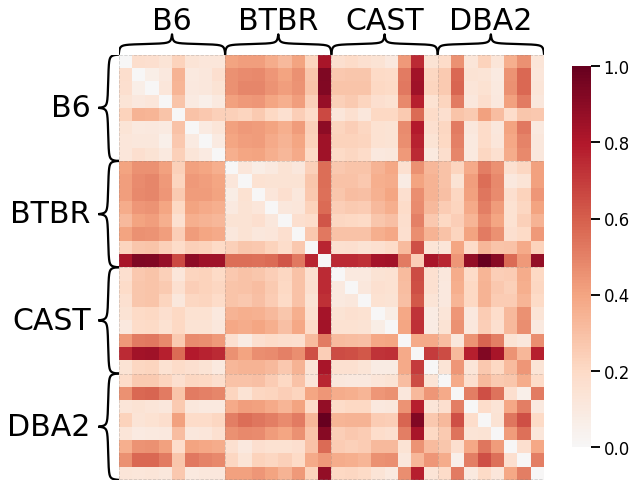

In [3]:
scaled_kdes = np.zeros((np.shape(graphs)[0], 2000))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    lap = to_laplacian(graph, 'I-DAD')
    #lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')
    
    # smooth eigenvalue spectrum using Gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w.reshape(-1, 1))
    xs = np.linspace(0, 2, 2000)
    xs = xs[:, np.newaxis]
    log_dens = kde.score_samples(xs)
    scaled_kdes[i] = np.exp(log_dens)

    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(scaled_kdes):
    for j, metric2 in enumerate(scaled_kdes):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=1)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

# construct labels
mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

## No Pass-to-Ranks Tranformation, Smoothing, L1 Norm

0.7230282738095237


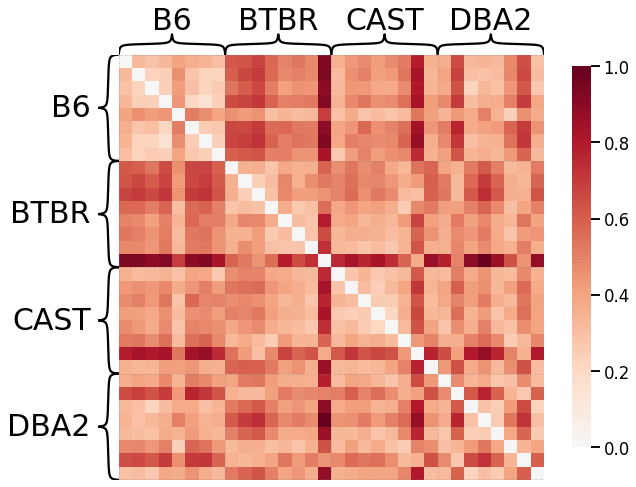

In [57]:
scaled_kdes = np.zeros((np.shape(graphs)[0], 2000))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    #graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    #lap = to_laplacian(graph, 'I-DAD')
    lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')
    
    # smooth eigenvalue spectrum using Gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w.reshape(-1, 1))
    xs = np.linspace(0, 2, 2000)
    xs = xs[:, np.newaxis]
    log_dens = kde.score_samples(xs)
    scaled_kdes[i] = np.exp(log_dens)

    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(scaled_kdes):
    for j, metric2 in enumerate(scaled_kdes):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=1)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

## Pass-to-Ranks Transformation, No Smoothing, L1 Norm

0.679501488095238


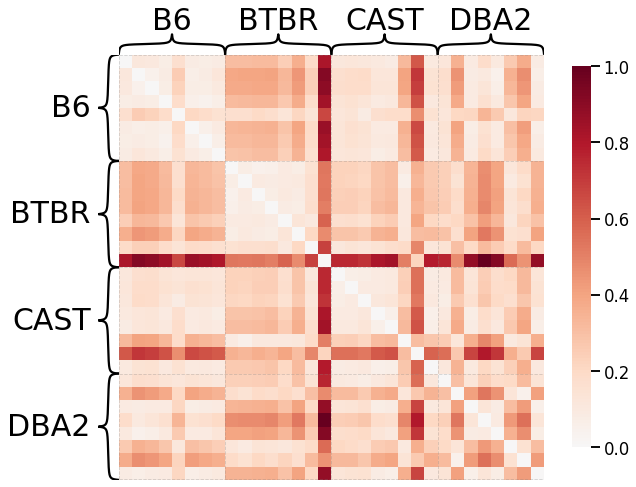

In [58]:
ws = np.zeros((np.shape(graphs)[0], 332))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    #lap = to_laplacian(graph, 'I-DAD')
    lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)
    w = np.sort(w)
    ws[i] = w

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')
    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(ws):
    for j, metric2 in enumerate(ws):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=1)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

## Pass-To-Ranks Transformation, Smoothing, L2 Norm

0.6339285714285714


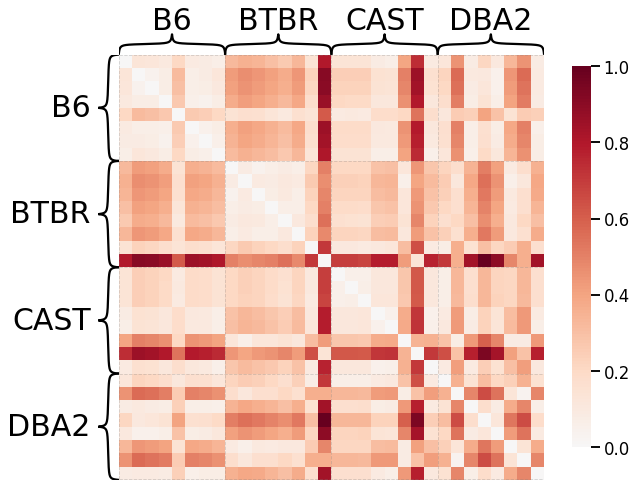

In [59]:
scaled_kdes = np.zeros((np.shape(graphs)[0], 2000))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    #lap = to_laplacian(graph, 'I-DAD')
    lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')

    # smooth eigenvalue spectrum using Gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w.reshape(-1, 1))
    xs = np.linspace(0, 2, 2000)
    xs = xs[:, np.newaxis]
    log_dens = kde.score_samples(xs)
    scaled_kdes[i] = np.exp(log_dens)
    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(scaled_kdes):
    for j, metric2 in enumerate(scaled_kdes):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=2)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

## No Pass-To-Ranks Transformation, No Smoothing, L1 Norm

0.6702008928571429


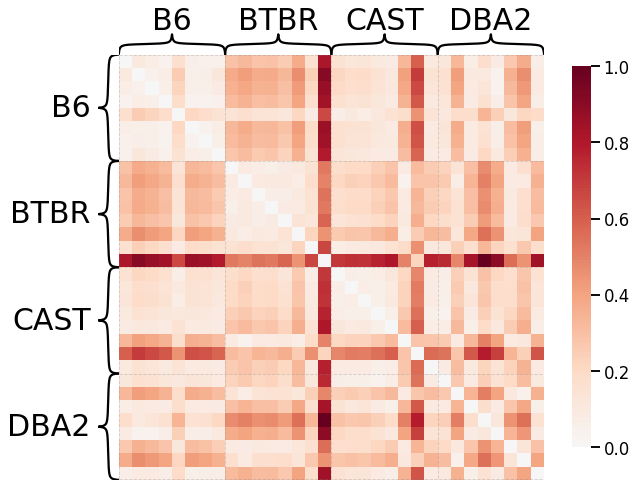

In [5]:
ws = np.zeros((np.shape(graphs)[0], 332))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    #graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    #lap = to_laplacian(graph, 'I-DAD')
    lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)
    w = np.sort(w)
    ws[i] = w

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')
    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(ws):
    for j, metric2 in enumerate(ws):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=1)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

In [6]:
print(ws)
print(w)

[[ 1.13293720e-16  6.06834243e-01  8.19185330e-01 ...  1.09864722e+00
   1.11427659e+00  1.14425326e+00]
 [-5.22548020e-17  5.60308328e-01  8.07844353e-01 ...  1.11770137e+00
   1.12472305e+00  1.16144067e+00]
 [ 1.47565174e-17  6.30717558e-01  8.27135367e-01 ...  1.11424369e+00
   1.11587766e+00  1.14401116e+00]
 ...
 [-9.12427028e-17  5.58108633e-01  7.20964694e-01 ...  1.11149436e+00
   1.12171935e+00  1.14026108e+00]
 [-1.09968223e-16  4.90486885e-01  6.85365884e-01 ...  1.12400294e+00
   1.13165234e+00  1.14975451e+00]
 [-5.43832129e-17  6.38620630e-01  7.59396744e-01 ...  1.08944016e+00
   1.10441809e+00  1.13662051e+00]]
[-5.43832129e-17  6.38620630e-01  7.59396744e-01  8.11792008e-01
  8.62017901e-01  8.68884606e-01  8.99148609e-01  9.12593824e-01
  9.21930982e-01  9.24313360e-01  9.30077501e-01  9.38387950e-01
  9.41521707e-01  9.43026349e-01  9.45078927e-01  9.48822262e-01
  9.51554773e-01  9.53883611e-01  9.57101976e-01  9.57313597e-01
  9.59785897e-01  9.61763960e-01  9.625

## No Pass-To-Ranks Transformation, Smoothing, L2 Norm

0.6856398809523808


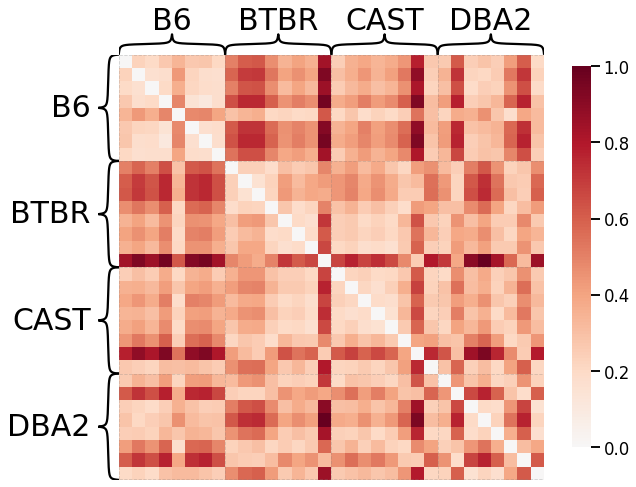

In [61]:
scaled_kdes = np.zeros((np.shape(graphs)[0], 2000))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    #graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    #lap = to_laplacian(graph, 'I-DAD')
    lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')

    # smooth eigenvalue spectrum using Gaussian kernel
    kde = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(w.reshape(-1, 1))
    xs = np.linspace(0, 2, 2000)
    xs = xs[:, np.newaxis]
    log_dens = kde.score_samples(xs)
    scaled_kdes[i] = np.exp(log_dens)
    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(scaled_kdes):
    for j, metric2 in enumerate(scaled_kdes):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=2)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

## Pass-To-Ranks Transformation, No Smoothing, L2 Norm

0.7743675595238095


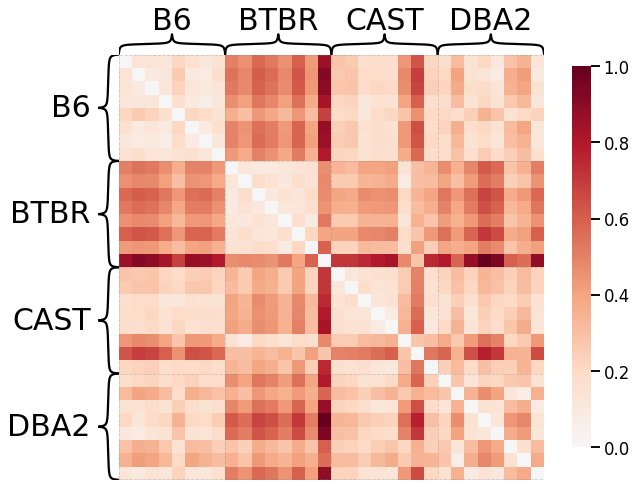

In [3]:
ws = np.zeros((np.shape(graphs)[0], 332))

for i, graph in enumerate(graphs):
    # make graphs unweighted (binary)
    #graph[np.nonzero(graph)] = 1

    # pass-to-ranks transformation
    graph = pass_to_ranks(graph)

    # find normalized laplacian of each adjacency matrix
    #lap = to_laplacian(graph, 'I-DAD')
    lap = csgraph.laplacian(graph, normed=True)
    #diags = np.sum(graph, axis=1)
    #deg_mat = np.diag(diags)
    #lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graph)

    # find eigenvalues
    w = np.linalg.eigvals(lap)
    w = np.sort(w)
    ws[i] = w

    # check eigenvalues are between 0 and 2
    if np.any(w < - 0.005):
        print('Eigenvalues must be >= 0.')
    if np.any(w > 2.005):
        print('Eigenvalues must be <= 2.')
    
dissim_matrix = np.zeros((len(graphs), len(graphs)))
for i, metric1 in enumerate(ws):
    for j, metric2 in enumerate(ws):
            #diff = cosine(metric1, metric2)
            diff = np.linalg.norm(metric1 - metric2, ord=2)
            dissim_matrix[i, j] = diff

scaled_dissim = dissim_matrix / np.max(dissim_matrix)

ax = heatmap(scaled_dissim, context="talk", inner_hier_labels=mice.labels)
ax.figure.set_facecolor('w')

mapper = {'B6': 0, 'BTBR': 1, 'CAST': 2, 'DBA2': 3}
y = np.array([mapper[l] for l in list(mice.labels)])
discrim_stat = discrim.statistic(scaled_dissim, y)
print(discrim_stat)

## Visualizing Eigenvalue Spectrum

Using pass-to-ranks transformation, smoothing, L2 norm - based on highest discriminability

### Eigenvalue Spectrum of Graph 0

Text(0, 0.5, 'Eigenvalue')

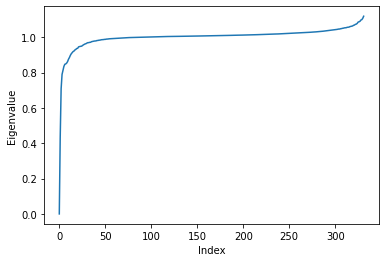

In [68]:
### Based on sorted index
plt.figure(facecolor='w')
plt.plot(ws[0])
plt.xlabel('Sorted Index')
plt.ylabel('Eigenvalue')

Text(0.5, 0, 'Eigenvalue')

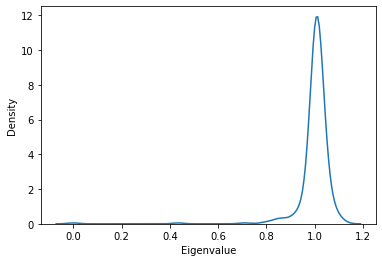

In [70]:
### Based on density / frequency
import seaborn as sns

plt.figure(facecolor='w')
sns.kdeplot(ws[0])
plt.xlabel('Eigenvalue')

### Comparing Eigenvalue Spectrum to Most Similar and Dissimilar Graphs based on L2 Norm

In [9]:
# find most similar and dissimilar graph from graph 0 based on diff metric
sim_idx = np.argmin(scaled_dissim[0, 1:]) + 1
dissim_idx = np.argmax(scaled_dissim[0, 1:]) + 1

print(sim_idx)
print(dissim_idx)

2
23


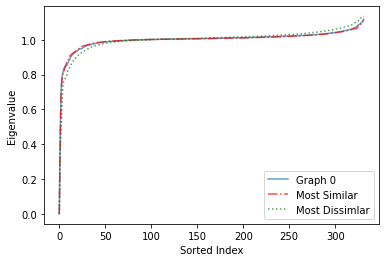

In [10]:
### Based on sorted index
plt.figure(facecolor='w')
plt.plot(ws[0], alpha=0.7, label = 'Graph 0')
plt.plot(ws[2], 'r-.', alpha=0.7, label='Most Similar')
plt.plot(ws[23], 'g:', alpha=0.7, label='Most Dissimlar')
plt.xlabel('Sorted Index')
plt.ylabel('Eigenvalue')
plt.legend()

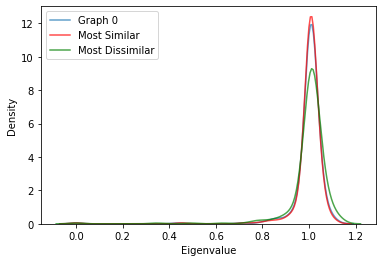

In [11]:
### Based on density / frequency
import seaborn as sns

plt.figure(facecolor='w')
sns.kdeplot(ws[0], alpha=0.7, label='Graph 0')
sns.kdeplot(ws[2], color='red', alpha=0.7, label='Most Similar')
sns.kdeplot(ws[23], color='green', alpha=0.7, label='Most Dissimilar')
plt.xlabel('Eigenvalue')
plt.legend()

### Smoothing Eigenvalue Spectrum with Gaussian Kernel

1.0
(2000,)
0.08026985446497661


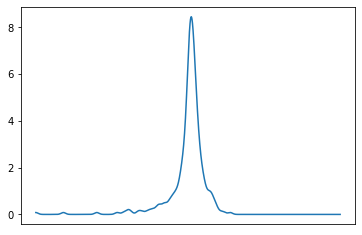

In [41]:
### running one example
diags = np.sum(graphs[0], axis=1)
deg_mat = np.diag(diags)
lap = np.eye(np.shape(graphs)[1]) - np.matmul(np.linalg.inv(deg_mat), graphs[0])
ws = np.linalg.eigvals(lap)

xs = np.linspace(0, 2, 2000)
kde = np.zeros(np.shape(xs))
for i, x in enumerate(xs):
    temp = np.exp(-(np.abs(x - ws)**2)/ (2 * 0.015**2)) / np.sqrt(2 * np.pi * 0.0015**2)
    temp_sum = np.sum(temp)
    kde[i] = temp_sum

scaled_kdes = np.zeros((2, 2000))
scaled_kde = kde / np.trapz(kde, dx=0.001)
scaled_kdes[1] = scaled_kde
print(np.trapz(scaled_kde, dx=0.001))
print(np.shape(scaled_kde))
print(np.max(scaled_kde[0]))

fig = plt.figure(facecolor='w')
plt.xticks([])
plt.plot(scaled_kde)

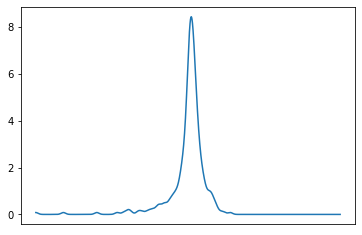

In [60]:
### try gaussian kernel from sklearn
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.015).fit(ws.reshape(-1, 1))
plot_xs = xs[:, np.newaxis]
log_dens = kde1.score_samples(plot_xs)
plt.figure(facecolor='w')
plt.xticks([])
plt.plot(plot_xs[:, 0], np.exp(log_dens))

In {cite:t}`suarez2022taxonomy`, the Laplacian eigenspectrum for each binarized graph was smoothed using a Gaussian kernel, and dissimilarity was calculated as the cosine difference between the eigenspectra. In order to ensure the accuracy of our Laplacian spectral kernel, we attempt to replicate their Fig 2(a) (double check!! maybe move to appendix?).